In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import * 

from mlxtend.plotting import plot_decision_regions 

%matplotlib inline

/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/abulbasar/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be remove

In [4]:
df_train = pd.read_csv("/data/MNIST/mnist_train.csv", header=None)
df_test = pd.read_csv("/data/MNIST/mnist_test.csv", header = None)

In [5]:
df_train.shape, df_test.shape

((60000, 785), (10000, 785))

In [6]:
y_train = df_train.iloc[:, 0]
y_test = df_test.iloc[:, 0]

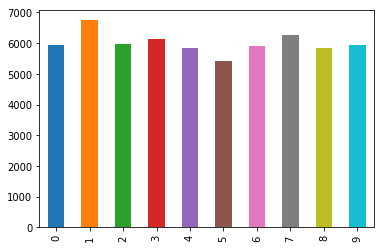

In [11]:
y_train.value_counts().sort_index().plot.bar()

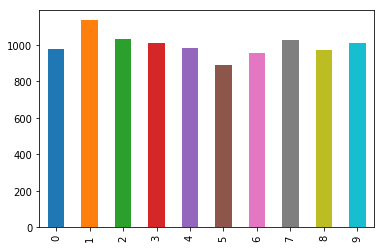

In [12]:
y_test.value_counts().sort_index().plot.bar()

In [78]:
scaler = preprocessing.StandardScaler()
X_train = df_train.values[:, 1:].astype(np.float32)
X_test = df_test.values[:, 1:].astype(np.float32)
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [29]:
X_test_std.shape

(10000, 784)

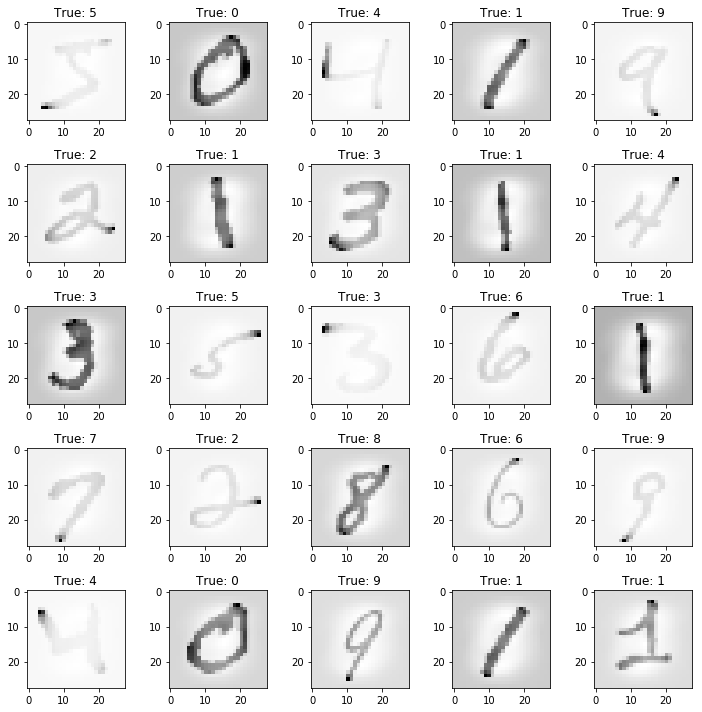

In [37]:
fig, _ = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(fig.axes):
    ax.imshow(X_train_std[i].reshape(28, 28), cmap="Greys", interpolation="nearest")
    ax.set_title("True: " + str(y_train[i]))
plt.tight_layout()

In [88]:
%%time
pipe = pipeline.Pipeline([
    ("poly", preprocessing.PolynomialFeatures(degree=1, include_bias=False)),
    ("scaler", preprocessing.StandardScaler()),
    ("model", linear_model.SGDClassifier(alpha=0.05, tol=1e-5, learning_rate="invscaling", 
            eta0=0.1, max_iter=10000, random_state=1))
    
])
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print("Test accuracy", score, "iteration: ", pipe.steps[2][1].n_iter_)

Test accuracy 0.9111 iteration:  23
CPU times: user 8.62 s, sys: 620 ms, total: 9.24 s
Wall time: 9.26 s


In [46]:
y_test_pred = sgd.predict(X_test_std) 

In [48]:
result = pd.DataFrame({"actual": y_test, "pred": y_test_pred})
result["match"] = result.actual == result.pred
result.head()

,actual,pred,match
0,7,7,True
1,2,2,True
2,1,1,True
3,0,0,True
4,4,4,True


In [68]:
result_agg = result.groupby(["actual", "match"]).count().unstack()
result_agg

pred      
match  False True 
actual            
0         17   963
1         23  1112
2        120   912
3         94   916
4         70   912
5        121   771
6         50   908
7         73   955
8        137   837
9        126   883

In [70]:
result_agg = pd.DataFrame(result_agg.values)

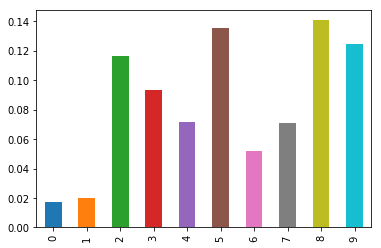

In [73]:
pd.Series(result_agg.loc[:, 0] / (result_agg.loc[:, 0] + result_agg.loc[:, 1])).plot.bar()

In [89]:
pca = decomposition.PCA()
pca.fit(X_train_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0,0.5,'Explained variance ratio')

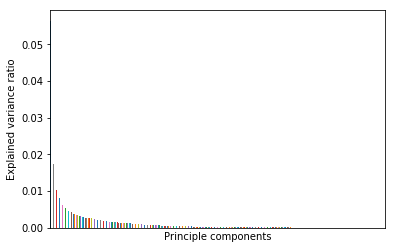

In [96]:
pd.Series(pca.explained_variance_ratio_).plot.bar()
plt.xticks([])
plt.xlabel("Principle components")
plt.ylabel("Explained variance ratio")

Text(0,0.5,'Commulative explain variance retention')

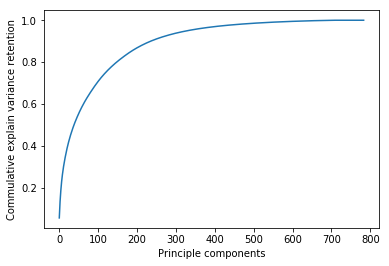

In [98]:
pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot()
plt.xlabel("Principle components")
plt.ylabel("Commulative explain variance retention")

In [102]:
pd.DataFrame({"explained": np.cumsum(pca.explained_variance_ratio_)}).query("explained> 0.99").head()

,explained
542,0.990089
543,0.990183
544,0.990277
545,0.990370
546,0.990462


In [103]:
%%time
pipe = pipeline.Pipeline([
    ("poly", preprocessing.PolynomialFeatures(degree=1, include_bias=False)),
    ("scaler", preprocessing.StandardScaler()),
    ("pca", decomposition.PCA(n_components=542)),
    ("model", linear_model.SGDClassifier(alpha=0.05, tol=1e-5, learning_rate="invscaling", 
            eta0=0.1, max_iter=10000, random_state=1))
    
])
pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print("Test accuracy", score, "iteration: ", pipe.steps[3][1].n_iter_)

Test accuracy 0.9106 iteration:  23
CPU times: user 30.9 s, sys: 1.55 s, total: 32.5 s
Wall time: 18.2 s


In [104]:
pca = decomposition.PCA(n_components=542)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [105]:
%%time
pipe = pipeline.Pipeline([
#    ("poly", preprocessing.PolynomialFeatures(degree=1, include_bias=False)),
#    ("scaler", preprocessing.StandardScaler()),
#    ("pca", decomposition.PCA(n_components=542)),
    ("model", linear_model.SGDClassifier(alpha=0.05, tol=1e-5, learning_rate="invscaling", 
            eta0=0.1, max_iter=10000, random_state=1))
    
])
pipe.fit(X_train_pca, y_train)
score = pipe.score(X_test_pca, y_test)
print("Test accuracy", score, "iteration: ", pipe.steps[0][1].n_iter_)

Test accuracy 0.9103 iteration:  21
CPU times: user 5.72 s, sys: 170 ms, total: 5.89 s
Wall time: 5.85 s
